# RP-GPFA: Lorenz attractor

Recognition Parametrised GPFA (RP-GPFA) recovers the Lorenz dynamics from Poisson Noise observation
without modeling explicitely its generative process.

The Lorenz attractor obeys

\begin{equation}
\begin{split}
\dot z_1  &= \sigma (z_2 - z_1) \\
\dot z_2  &= z_1 (\rho - z_3) - z_2 \\
\dot z_3  &= z_1 z_2 - \beta z
\end{split}
\end{equation}

From which we decude the rates $\mathsf{r}(t) = \exp( C \mathsf{z}(t) + d)$ and the observations

\begin{equation}
\mathsf{x}(t) \sim \text{Poisson} ( \mathsf{r}(t))
\end{equation}

For $n=1..N$, each observation correspond to a slightly different initialisation of the the attractor,
noise sampled from a Gaussian process, and Poisson sampling.


Imports:

In [1]:
import torch
import numpy as np
from torch import matmul
import matplotlib.pyplot as plt

from utils_generate_toydatasets import generate_lorenz
from kernels import RBFKernel

import torch
import numpy as np
from torch import matmul
import matplotlib.pyplot as plt
from kernels import RBFKernel
import torch.nn.functional as F
from utils_generate_toydatasets import generate_lorenz
from mpl_toolkits.mplot3d import Axes3D

from recognition_parametrised_model import RPM
import torch.nn.functional as F


In [2]:
# Reproducibility
np.random.seed(1)
torch.manual_seed(1)

# GPUs ?
dtype = torch.float64
torch.set_default_dtype(dtype)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dimension of the problem
dim_observations = 200
num_observations = 10
len_observations = 100
num_inducing_points = 50
dim_latent_true = 3

# Generate Lorenz Dynamics
dtt_simulation = 0.001   # a.u
len_simulation = 3e3
num_simulation = num_observations
dim_simulation = 3
init_simulation = np.array([2.3274,  3.8649, 18.2295])
vari_simulation = 0.1

# Normalize Lorenz Dynamics to [-1, 1]
lorenz_raw = torch.tensor(generate_lorenz(num_simulation, int(len_simulation) -1, dtt_simulation, init_simulation, vari_simulation), dtype=dtype)
lorenz_nor = lorenz_raw.reshape(lorenz_raw.shape[0] * lorenz_raw.shape[1], dim_simulation)
lorenz_nor -= lorenz_nor.min(dim=0, keepdim=True)[0]
lorenz_nor /= lorenz_nor.max(dim=0, keepdim=True)[0]
lorenz_nor = 2 * lorenz_nor - 1

# Reshape Dynamics
lorenz_nor = lorenz_nor.reshape(num_simulation, int(len_simulation), dim_simulation)
time_idx = np.linspace(0, len_simulation-1, len_observations).round().astype(int)
lorenz_nor = lorenz_nor[:, time_idx]

# Add Gaussian Noise To each trajectories
noise_kernel = RBFKernel(0.1 * torch.ones(dim_simulation), 0.1 * torch.ones(dim_simulation))
KK = noise_kernel(torch.linspace(0, 1, len_observations).unsqueeze(-1), torch.linspace(0, 1, len_observations).unsqueeze(-1))
LL = torch.linalg.cholesky(KK + 1e-6 * torch.eye(len_observations).unsqueeze(0) )
noise = matmul(LL, torch.randn(dim_simulation, len_observations, num_observations)).permute(2, 1, 0).detach()
lorenz_nor = lorenz_nor + noise + 0 * 2 * torch.rand(lorenz_nor.shape)


# Unfold dynamics for ploting
lorenz_nor = lorenz_nor.reshape(num_simulation * len_observations, dim_simulation)
lorenz_nor = lorenz_nor[..., :dim_latent_true]

# True Latents
latent_true_unfolded = lorenz_nor
latent_true = latent_true_unfolded.reshape(num_observations, len_observations, dim_latent_true)

# Map to observations
C = torch.rand(lorenz_nor.shape[-1], dim_observations)

# Rates
rates_unfoled = matmul(lorenz_nor, C)
rates = rates_unfoled.reshape(num_observations, len_observations, dim_observations)

# Observations
#observations = rates + 0.3 * torch.randn(rates.shape)
observations = torch.poisson(torch.exp((rates - rates.min())))
observations_unfoled = observations.reshape(num_observations * len_observations, dim_observations)

/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones

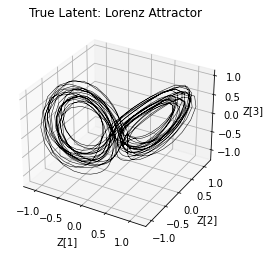

In [3]:
if dim_latent_true == 3:
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(lorenz_nor[:, 0], lorenz_nor[:, 1], lorenz_nor[:, 2], lw=0.5, color='k')
    ax.set_xlabel("Z[1]")
    ax.set_ylabel("Z[2]")
    ax.set_zlabel("Z[3]")
    ax.set_title("True Latent: Lorenz Attractor")
elif dim_latent_true == 2:
    plt.figure()
    plt.plot(lorenz_nor[:, 0], lorenz_nor[:, 1], lw=0.5, color='k')
    plt.xlabel("Z[1]")
    plt.ylabel("Z[2]")
    plt.title("True Latent: Lorenz Attractor")
else:
    plt.figure()
    yy = lorenz_nor.reshape(num_simulation, len_observations, dim_latent_true)
    for nn in range(num_observations):
        plt.plot(yy[nn], color='k')
    plt.title("True Latent: Lorenz Attractor")
    plt.ylabel('Z[1]')
    plt.xlabel('Time [a.u]')



Text(0.5, 1.0, 'Latent#2')

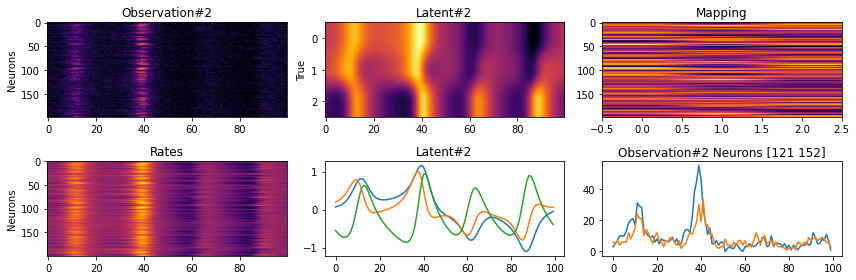

In [4]:
# Plot Observation Summary
plt.figure(figsize=(3*4, 4))
plot_n = 2
plot_num = 2
plot_id = np.random.choice(dim_observations, plot_num)
cmap = 'inferno'

# Plot Observations
plt.subplot(2, 3, 1)
plt.imshow(observations[plot_n].transpose(-1, -2), aspect='auto', cmap=cmap)
plt.ylabel('Neurons')
plt.title('Observation#' + str(plot_n))

# Plot Rates
plt.subplot(2, 3, 4)
plt.imshow(rates[plot_n].transpose(-1, -2), aspect='auto', cmap=cmap)
plt.title('Rates')
plt.ylabel('Neurons')

# Plot Observations
plt.subplot(2, 3, 6)
plt.plot(observations[plot_n, :, plot_id])
plt.title('Observation#' + str(plot_n) + ' Neurons ' + str(plot_id))

# Plot Mapping
plt.subplot(2, 3, 3)
plt.imshow(C.transpose(-1, -2), aspect='auto', cmap='inferno')
plt.title('Mapping')

# Plot True Latent
plt.subplot(2, 3, 2)
plt.imshow(latent_true[plot_n].transpose(-1, -2), aspect='auto', cmap=cmap)
plt.ylabel('True')
plt.title('Latent#' + str(plot_n))

# Plot True Latents
plt.subplot(2, 3, 5)
plt.plot(latent_true[plot_n])
plt.tight_layout()
plt.title('Latent#' + str(plot_n))


In [5]:

# Normalise observations.
observations = observations.reshape(num_observations * len_observations, dim_observations)
o_mean, o_std = torch.mean(observations, dim=0, keepdim=True), torch.std(observations, dim=0, keepdim=True)
observations = (observations - o_mean) / o_std
observations = observations.reshape(num_observations, len_observations, dim_observations)

# Move to GPU if necessary
observations = torch.tensor(observations, dtype=dtype, device=device)
observation_locations = torch.linspace(0, 1, len_observations, dtype=dtype, device=device).unsqueeze(-1)
inducing_locations = torch.linspace(0, 1, num_inducing_points, dtype=dtype, device=device).unsqueeze(-1)

# Break Into Multiple Factors
num_factors = 1
num_full = (np.floor(dim_observations / num_factors)).astype(int)
obs = tuple([observations[..., num_full*i:num_full*(i+1)] for i in range(num_factors)])

/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [6]:

prior_params = {
    'gp_kernel': 'RBF',
    'optimizer': {'name': 'Adam', 'param': {'lr': 1e-3}},
    'scale': 1,
    'scale_prior':1,
    'lengthscale': 0.01,
    'lengthscale_prior':0.02,
    'fit_prior_mean_param':True,
    'fit_kernel_scale':False,
    'fit_kernel_scale_prior':False,
    'fit_kernel_lengthscale':True,
    'fit_kernel_lengthscale_prior':True,
}


factors_params = {
    'channels': [[]],
    'kernel_conv': [[]],
    'kernel_pool': [[]],
    'dim_hidden': [[10, 10]],
    'non_linearity': [F.relu],
    'covariance': ['fixed_diag'],
    'optimizer': {'name': 'Adam', 'param': {'lr': 1e-5}},
}

auxiliary_params = {
    'channels': [[]],
    'kernel_conv': [[]],
    'kernel_pool': [[]],
    'dim_hidden': [[10, 10]],
    'non_linearity': [F.relu],
    'covariance': ['fixed_diag'],
    'optimizer': {'name': 'Adam', 'param': {'lr': 0e-5}},
}

variational_params = {
    'inference_mode': 'parametrized',  # 'amortized', 'parametrized'
    'channels': [[]],
    'kernel_conv': [[]],
    'kernel_pool': [[]],
    'dim_hidden': [[10, 10]],
    'dim_hidden_merged': [],
    'non_linearity': [F.relu],
    'non_linearity_merged': F.relu,
    'covariance': 'full',
    'optimizer': {'name': 'Adam', 'param': {'lr': 1e-3}},
}

fit_params = {
    'num_epoch': 100000,
    'dim_latent': 3,
    'prior_params': prior_params,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'variational_params': variational_params,
    'pct':0.01,
}


# Reproducibility
np.random.seed(10)
torch.manual_seed(10)

rpm = RPM(
    observations=obs,
    observation_locations=observation_locations,
    inducing_locations=inducing_locations,
    fit_params=fit_params,
)


rpm.fit(obs)

RPM on GPU Observations on cuda:0
Epoch 1000/100000 Loss: 2.400739e+00
Epoch 2000/100000 Loss: 2.388656e+00
Epoch 3000/100000 Loss: 2.357950e+00
Epoch 4000/100000 Loss: 2.285535e+00
Epoch 5000/100000 Loss: 2.204668e+00
Epoch 6000/100000 Loss: 2.134925e+00
Epoch 7000/100000 Loss: 2.083312e+00
Epoch 8000/100000 Loss: 2.040301e+00
Epoch 9000/100000 Loss: 1.996267e+00
Epoch 10000/100000 Loss: 1.951758e+00
Epoch 11000/100000 Loss: 1.908901e+00
Epoch 12000/100000 Loss: 1.869188e+00
Epoch 13000/100000 Loss: 1.838458e+00
Epoch 14000/100000 Loss: 1.798620e+00
Epoch 15000/100000 Loss: 1.766233e+00
Epoch 16000/100000 Loss: 1.739103e+00
Epoch 17000/100000 Loss: 1.705634e+00
Epoch 18000/100000 Loss: 1.677621e+00
Epoch 19000/100000 Loss: 1.652313e+00
Epoch 20000/100000 Loss: 1.627192e+00
Epoch 21000/100000 Loss: 1.605662e+00
Epoch 22000/100000 Loss: 1.582905e+00
Epoch 23000/100000 Loss: 1.562278e+00
Epoch 24000/100000 Loss: 1.543734e+00
Epoch 25000/100000 Loss: 1.524042e+00
Epoch 26000/100000 Loss: 

In [8]:
from save_load import rpm_save
rpm_save(rpm, 'lorrenz_tmp.pickle')

In [30]:
from utils_process import plot_loss, plot_rpgpfa_mixture, plot_rpgpfa_summary
from save_load import rpm_load
loaded_rpm, _ = rpm_load(
    'lorrenz_tmp.pickle', 
    observations=[obsi.cpu() for obsi in obs],
    observation_locations=observation_locations.cpu(),
)

RPM on GPU Observations on cpu


In [28]:
with torch.no_grad():
    loaded_rpm._update_all([obsi.cpu() for obsi in obs])

AttributeError: 'tuple' object has no attribute '_update_all'

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


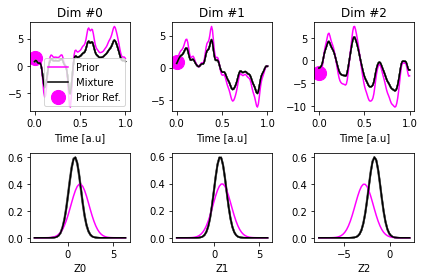

In [35]:
plot_rpgpfa_mixture(
    loaded_rpm,
    plot_id_factor=0,
    plot_id_index=0,
    plot_locations=50,
    plot_num_std=5,
)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

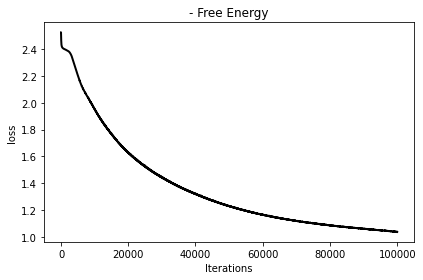

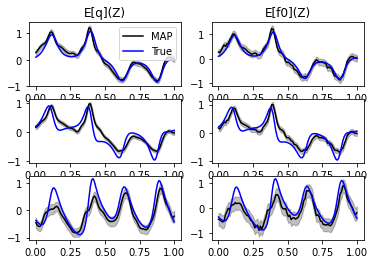

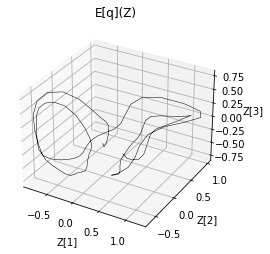

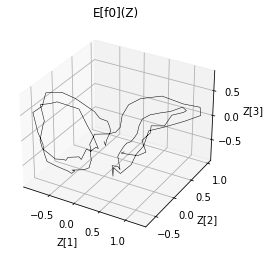

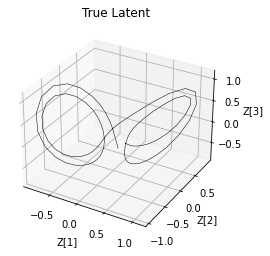

In [17]:
plot_loss(rpm)

plot_rpgpfa_summary(
    rpm=rpm,
    plot_id_factors=[0],
    plot_id_observations=[0],
    plot_variational=True,
    plot_regressed=True,
    plot_variance=True,
    plot_true=True,
    latent_true=latent_true,
    regress_param=None,
    plot_type='linear',
)

plot_rpgpfa_summary(
    rpm=rpm,
    plot_id_factors=[0],
    plot_id_observations=[0],
    plot_variational=True,
    plot_regressed=True,
    plot_variance=True,
    plot_true=True,
    latent_true=latent_true,
    regress_param=None,
    plot_type='3D',
)




NameError: name 'plot_loss' is not defined